In [132]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
data = pd.read_csv('Taxi.csv', index_col=0, parse_dates=True)

### Загрузил данные за половину 2016. Июнь 2016 будет тестовым месяцем

In [158]:
data=data.loc['2016-01-01':'2016-05-31']

## Создадим признаки годовой и недельной сезонности

In [159]:
F=pd.DataFrame(index=data.index)

In [160]:
F['y']=data

#### Проверим отсутствие тренда в данных

<AxesSubplot:>

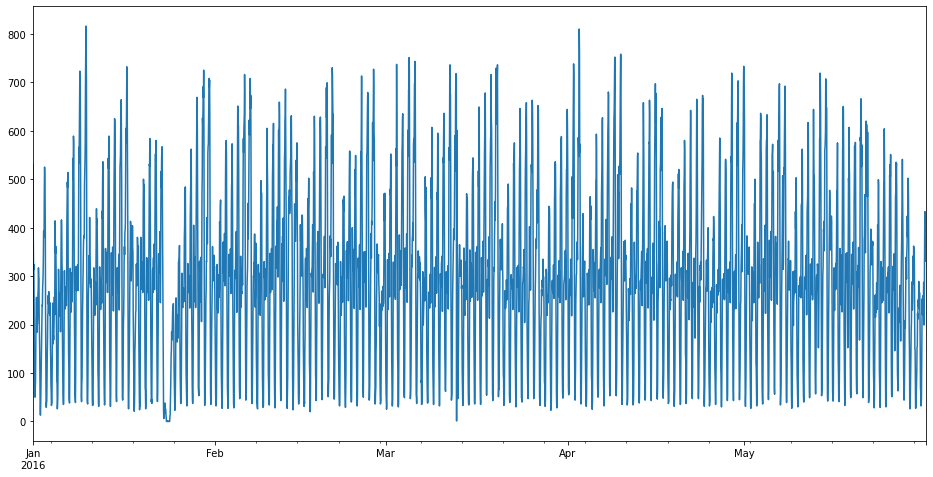

In [182]:
F.y.plot(figsize=(16,8))

### Недельная сезонность

In [161]:
for i in range(1, 6):
    F[f'w_s{i}']=np.sin(np.arange(1, data.shape[0]+1, 1)*2*np.pi*i/168)
    F[f'w_c{i}']=np.cos(np.arange(1, data.shape[0]+1, 1)*2*np.pi*i/168)

### Посмотрим на df:

In [162]:
F.head()

,y,w_s1,w_c1,w_s2,w_c2,w_s3,w_c3,w_s4,w_c4,w_s5,w_c5
2016-01-01 00:00:00,531,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566
2016-01-01 01:00:00,370,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874
2016-01-01 02:00:00,313,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724
2016-01-01 03:00:00,324,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052
2016-01-01 04:00:00,264,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820


## Построим регрессию

In [139]:
import statsmodels.formula.api as smf
import scipy as sc
import statsmodels.api as sm

Критерий Стьюдента: p=1.000000
Критерий Дики-Фуллера: p=0.000000


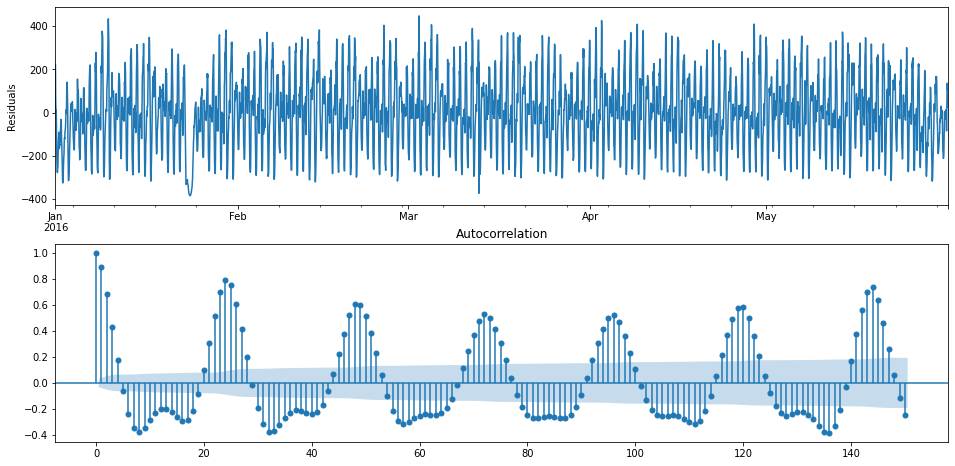

In [163]:
m2 = smf.ols('y ~ w_s1 + w_c1 + w_s2 + w_c2 + w_s3 + w_c3 + w_s4 + w_c4+'\
       'w_s5 + w_c5', data=F)
fitted = m2.fit()

plt.figure(figsize=(16,8))
plt.subplot(211)
fitted.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(fitted.resid.values.squeeze(), lags=150, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(fitted.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(fitted.resid)[1])

In [164]:
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     31.91
Date:                Wed, 07 Apr 2021   Prob (F-statistic):           7.63e-60
Time:                        16:07:30   Log-Likelihood:                -23813.
No. Observations:                3648   AIC:                         4.765e+04
Df Residuals:                    3637   BIC:                         4.772e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    298.0868      2.744    108.615      0.0

#### Остатки несмещены, ряд остатков стационарен, однако наблюдается высокая автокорреляция. Возможно она обусловлена суточной сезонностью, переходим к моделированию остатков моделью ARIMA

## Моделирование остатков регрессии

### 1. Преобразование Бокса-Кокса не требуется, поскольку дисперси стабильна во времени

### 2) Проведем STL декомпозицию ряда

In [165]:
F['resid']=fitted.resid

<AxesSubplot:title={'center':'Seasonal'}>

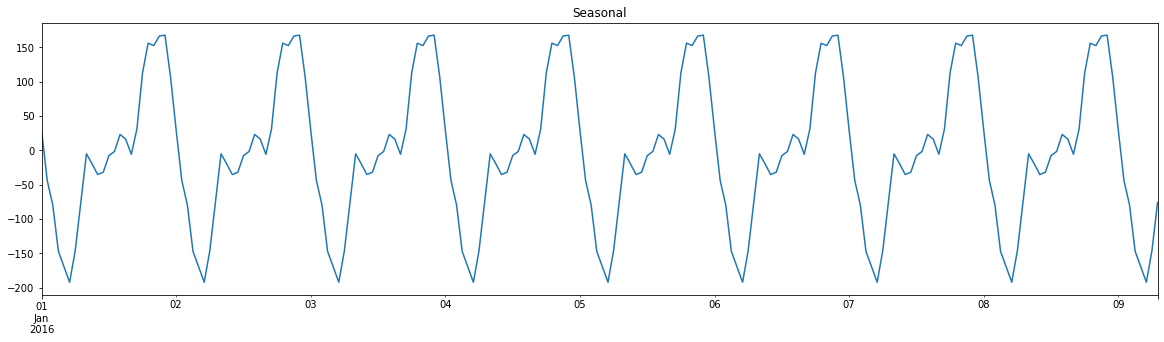

In [166]:
sm.tsa.seasonal_decompose(F['resid'][:200]).seasonal.plot(figsize=(20,5), title = 'Seasonal')

### Ярко-выраженная дневная сезонность

<AxesSubplot:title={'center':'Trend'}>

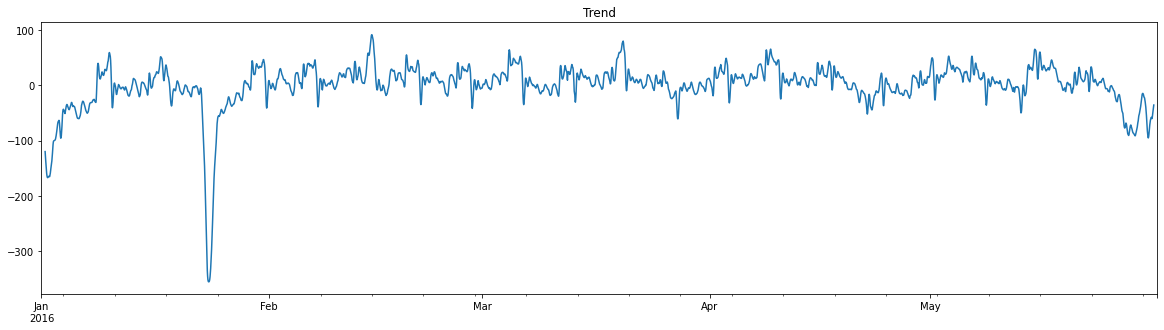

In [167]:
sm.tsa.seasonal_decompose(F['resid']).trend.plot(figsize=(20,5), title='Trend')

### Тренд отсутствует, но есть аномалии

<AxesSubplot:title={'center':'Residuals'}>

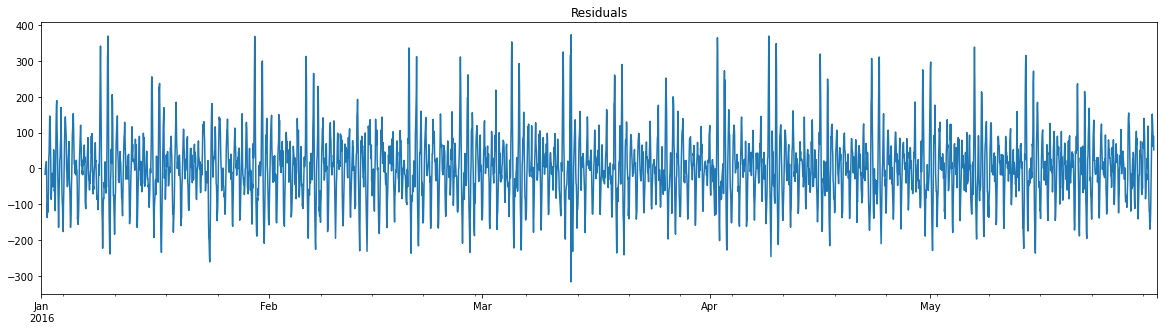

In [168]:
sm.tsa.seasonal_decompose(F['resid']).resid.plot(figsize=(20,5), title='Residuals')

### Остатки несмещены

## 3) Проведем дневное дифференцирование

<AxesSubplot:title={'center':'Seasonal'}>

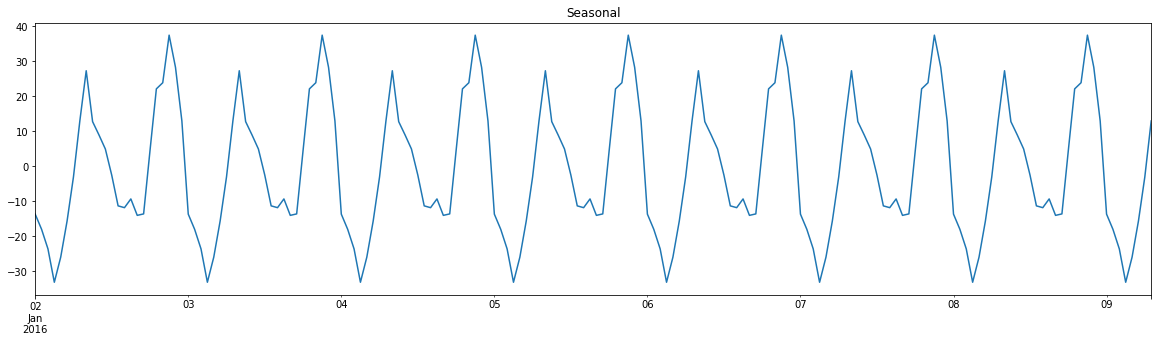

In [169]:
sm.tsa.seasonal_decompose(F['resid'].diff(24)[24:200]).seasonal.plot(figsize=(20,5), title = 'Seasonal')

<AxesSubplot:title={'center':'Trend'}>

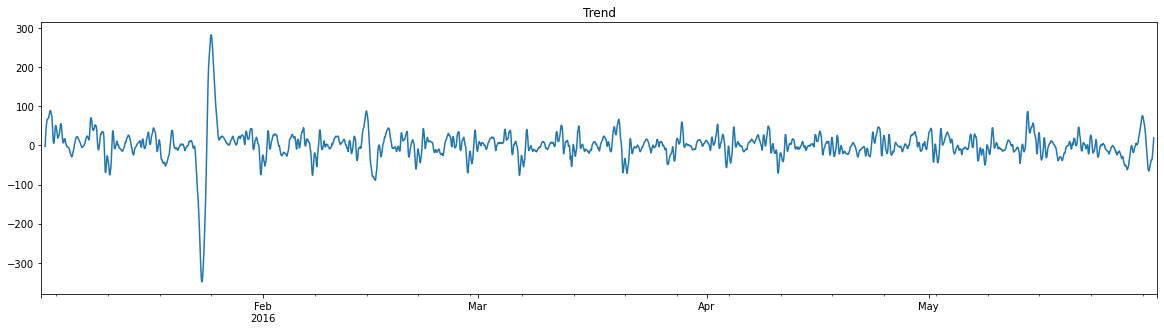

In [170]:
sm.tsa.seasonal_decompose(F['resid'].diff(24)[24:]).trend.plot(figsize=(20,5), title='Trend')

<AxesSubplot:title={'center':'Residuals'}>

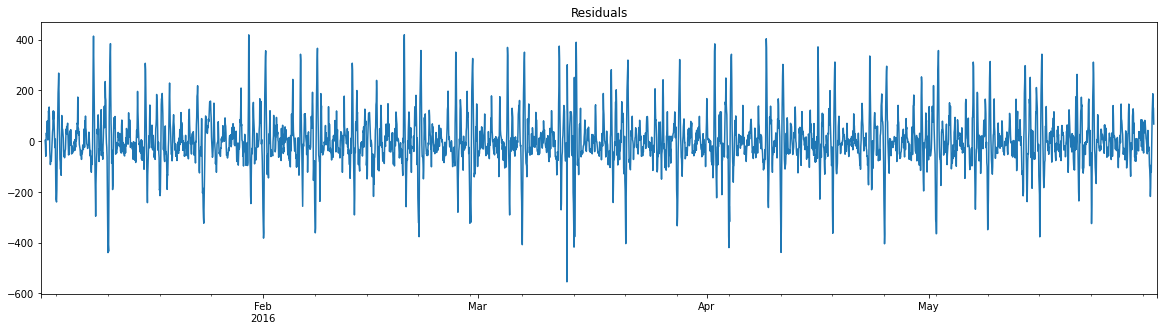

In [171]:
sm.tsa.seasonal_decompose(F['resid'].diff(24)[24:]).resid.plot(figsize=(20,5), title='Residuals')

In [172]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(F['resid'].diff(24)[24:])[1])

Критерий Дики-Фуллера: p=0.000000


### Картина стала существенно лучше. Двигаемся дальше

## 4) Оценим p,P, q,Q

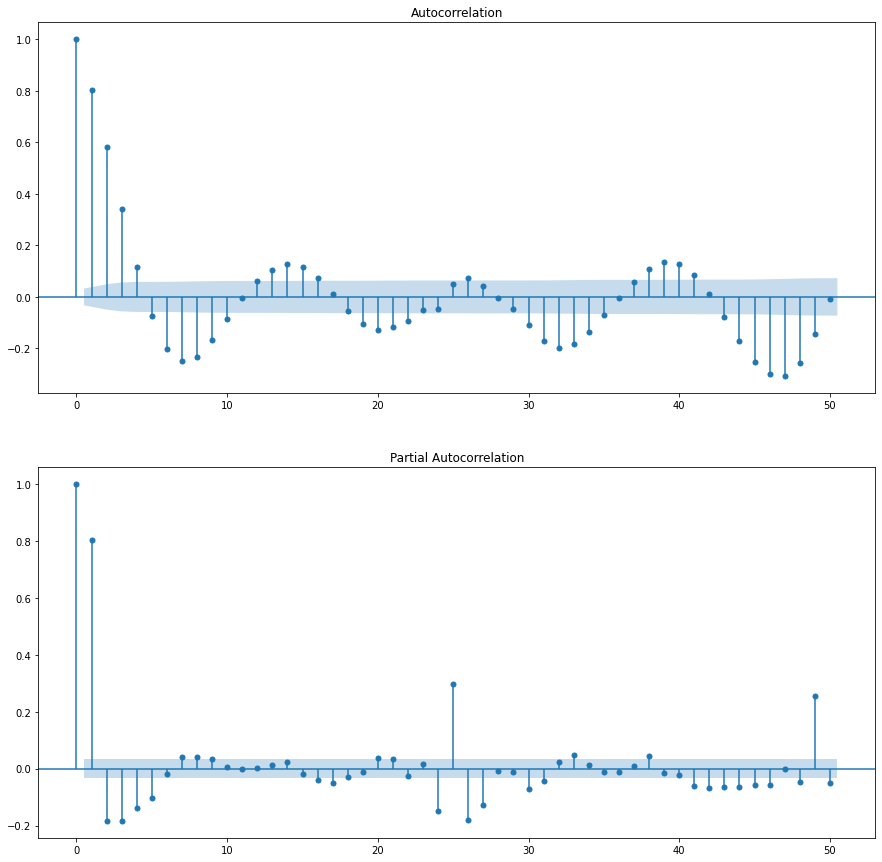

In [173]:
fig, ax = plt.subplots(2,1,figsize=(15,15))
sm.graphics.tsa.plot_acf(F['resid'].diff(24)[24:].values.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(F['resid'].diff(24)[24:].values.squeeze(), lags=50, ax=ax[1])
plt.show()

### Начальное приближение

Q=0, q=4, P=1, p=5

#Сезонность - 24 часа

In [174]:
ps = range(0, 6)
d=0
qs = range(0, 5)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [175]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

## 5) Подберем параметры модели

In [177]:
#!XL
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(F.y,
                                        exog=F[['w_s1', 'w_c1', 'w_s2', 'w_c2', 'w_s3', 'w_c3', 'w_s4', 'w_c4',
       'w_s5', 'w_c5']],
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)

    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

CPU times: user 14h 57min 19s, sys: 1d 3h 30min 2s, total: 1d 18h 27min 21s
Wall time: 2h 6min 50s


/kernel/lib/python3.7/site-packages/ml_kernel/logger.py:69: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  self._logger2.warn(message)


In [178]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
57  (5, 3, 1, 0)  39412.794730
49  (4, 4, 1, 0)  39434.783056
37  (3, 3, 1, 0)  39440.869947
39  (3, 4, 1, 0)  39480.856606
45  (4, 2, 1, 0)  39501.393102


In [179]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 3648
Model:             SARIMAX(5, 0, 3)x(1, 1, [], 24)   Log Likelihood              -19686.397
Date:                             Wed, 07 Apr 2021   AIC                          39412.795
Time:                                     18:22:37   BIC                          39536.701
Sample:                                 01-01-2016   HQIC                         39456.937
                                      - 05-31-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
w_s1          27.2958      5.825      4.686      0.000      15.880      38.712
w_c1          44.5133      

## 6) Анализ остатков

Критерий Стьюдента: p=0.901049
Критерий Дики-Фуллера: p=0.000000


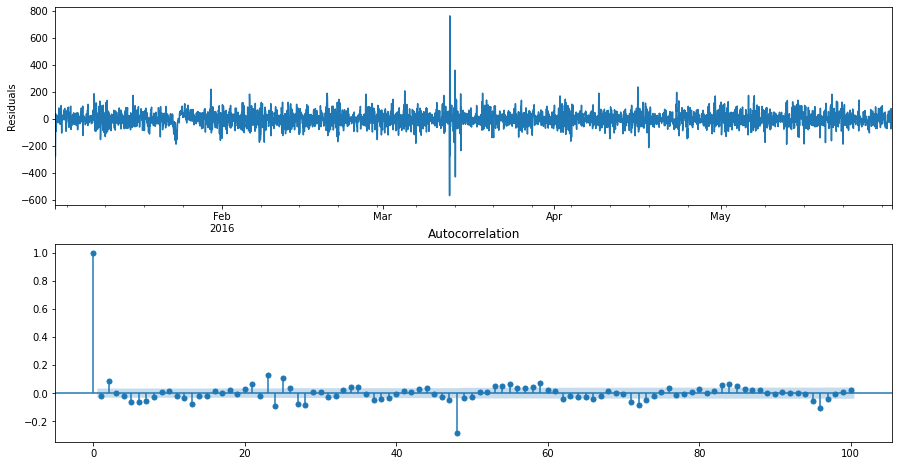

In [180]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[24:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[24:].values.squeeze(), lags=100, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[24:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[24:])[1])

#### Если судить по критерию Льюнга-Бокса остатки являются независимыми (отсутствует автокорреляция). Посмотрим также на их распределение и Q-Q plot:

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


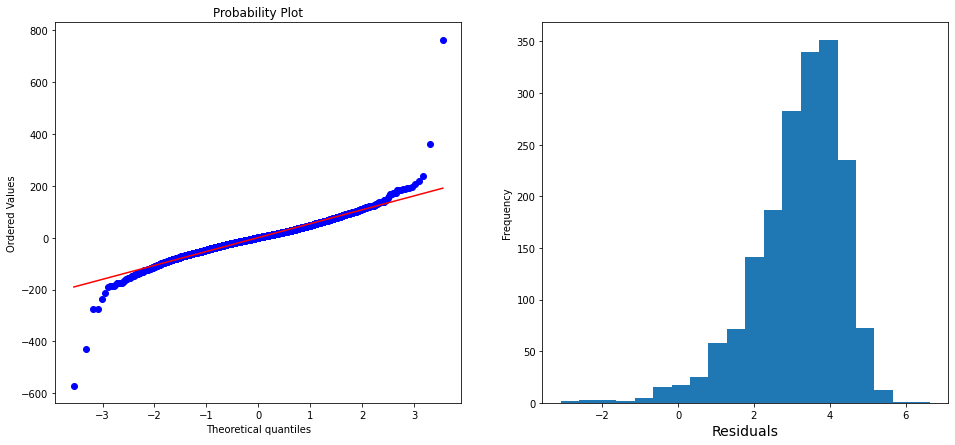

In [188]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sc.stats.probplot(best_model.resid[24:], dist="norm", plot=plt)
plt.subplot(122)
np.log(best_model.resid[24:]).plot.hist(bins=20)
plt.xlabel('Residuals', fontsize=14)
plt.show()

#### Пойдет. Все равно пересчитать у меня уже не хватит денег))

## 7) Проверка предсказаний

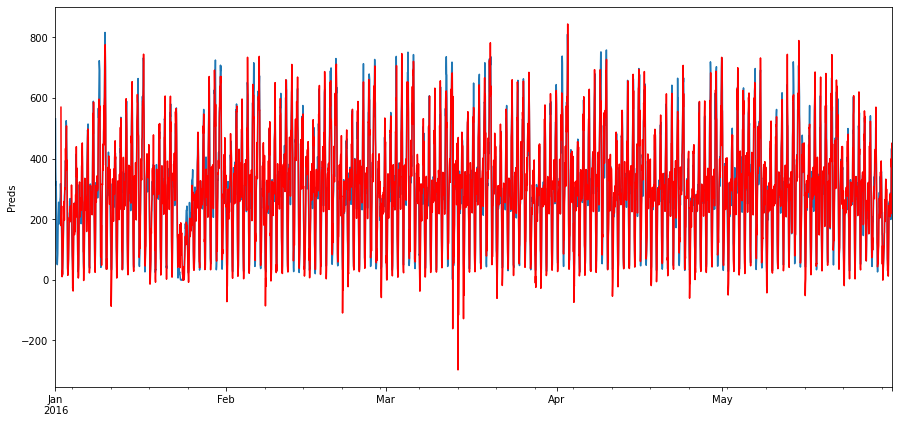

In [181]:
F['model'] = best_model.fittedvalues
plt.figure(figsize=(15,7))
F.y.plot()
F.model[24:].plot(color='r')
plt.ylabel('Preds')
plt.show()

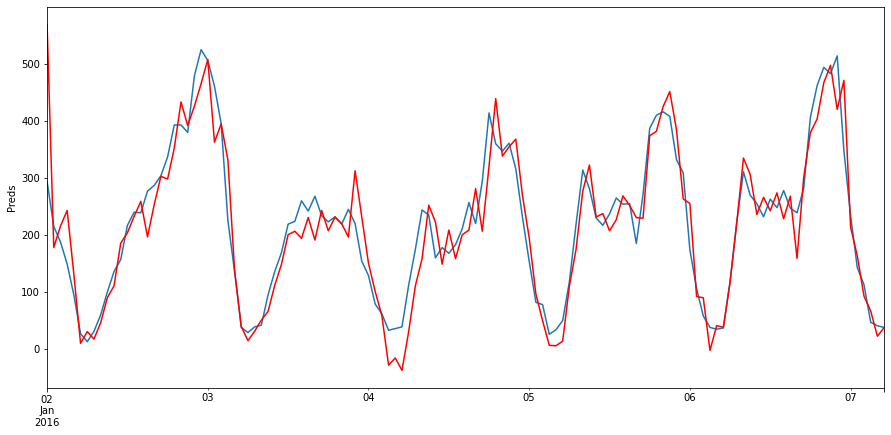

In [191]:
F['model'] = best_model.fittedvalues
plt.figure(figsize=(15,7))
F.y[24:150].plot()
F.model[24:150].plot(color='r')
plt.ylabel('Preds')
plt.show()

#### Модель отлично воспроизводит исторические данные

#### Считал через яндекс datasphere, там дается грант на 3к. И то более 2 часов считал на данных только за 5 месяцев! По деньгам вышло почти 1800р!